![](https://storage.googleapis.com/kaggle-competitions/kaggle/3338/media/gate.png)

## Amazon.com - Employee Access Challenge

When an employee at any company starts work, they first need to obtain the computer access necessary to fulfill their role. This access may allow an employee to read/manipulate resources through various applications or web portals. It is assumed that employees fulfilling the functions of a given role will access the same or similar resources. It is often the case that employees figure out the access they need as they encounter roadblocks during their daily work (e.g. not able to log into a reporting portal). A knowledgeable supervisor then takes time to manually grant the needed access in order to overcome access obstacles. As employees move throughout a company, this access discovery/recovery cycle wastes a nontrivial amount of time and money.

There is a considerable amount of data regarding an employee’s role within an organization and the resources to which they have access. Given the data related to current employees and their provisioned access, models can be built that automatically determine access privileges as employees enter and leave roles within a company. These auto-access models seek to minimize the human involvement required to grant or revoke employee access.

## Kernel's motivations

In this kernel we are going to show how deep learning (using TensorFlow 2.0 and Keras) can be effectively used when the problem involved regards tabular data. We will compare a deep neural network solution (DNN) to the best in class gradient boosting machine (GBM) algorithm when high cardinality variables are present and you will discover how not only a DNN solution is comparable, but also how it can integrate nicely with a GBM solution.

## Using a datagenerator for tabular data
The process of preparing the data is made easier and more efficient using a datagenerator from https://github.com/lmassaron/deep_learning_for_tabular_data The generator can handle into different pipelines numeric, ordinal, categorical (bot low and high cardinality) variables and it automatically takes care of missing values. You can also find in the repository a couple of useful activations for tabular data models: gelu (https://arxiv.org/abs/1606.08415) and mish (https://arxiv.org/abs/1908.08681).

In [1]:
# Assuring you have the most recent CatBoost release
!pip install catboost -U

     |████████████████████████████████| 64.0MB 35.7MB/s 
  Found existing installation: catboost 0.17.3
    Uninstalling catboost-0.17.3:
      Successfully uninstalled catboost-0.17.3


In [2]:
# Getting useful tabular processing and generator functions
!git clone https://github.com/lmassaron/deep_learning_for_tabular_data.git

Cloning into 'deep_learning_for_tabular_data'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 34 (delta 15), reused 5 (delta 1), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [3]:
# Importing core libraries
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Classifiers
from catboost import CatBoostClassifier, Pool

# Model selection
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import make_scorer

In [4]:
# Loading data directly from CatBoost
from catboost.datasets import amazon

X, Xt = amazon()

y = X["ACTION"].apply(lambda x: 1 if x == 1 else 0).values
X.drop(["ACTION"], axis=1, inplace=True)

In [5]:
# Transforming all the labels of all variables
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in range(X.shape[1])]

for col, column in enumerate(X.columns):
    label_encoders[col].fit(X[column].append(Xt[column]))
    X[column] = label_encoders[col].transform(X[column])
    Xt[column] = label_encoders[col].transform(Xt[column])

In [6]:
# Enconding frequencies instead of labels (so we have some numeric variables)

def frequency_encoding(column, df, df_test=None):
    frequencies = df[column].value_counts().reset_index()
    df_values = df[[column]].merge(frequencies, how='left', 
                                   left_on=column, right_on='index').iloc[:,-1].values
    if df_test is not None:
        df_test_values = df_test[[column]].merge(frequencies, how='left', 
                                                 left_on=column, right_on='index').fillna(1).iloc[:,-1].values
    else:
        df_test_values = None
    return df_values, df_test_values

for column in X.columns:
    train_values, test_values = frequency_encoding(column, X, Xt)
    X[column+'_counts'] = train_values
    Xt[column+'_counts'] = test_values

In [7]:
# Pointing out which variables are categorical and which are numeric
categorical_variables = [col for col in X.columns if '_counts' not in col]
numeric_variables = [col for col in X.columns if '_counts' in col]

In [8]:
X.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,RESOURCE_counts,MGR_ID_counts,ROLE_ROLLUP_1_counts,ROLE_ROLLUP_2_counts,ROLE_DEPTNAME_counts,ROLE_TITLE_counts,ROLE_FAMILY_DESC_counts,ROLE_FAMILY_counts,ROLE_CODE_counts
0,3050,4440,21,65,319,4,7,65,4,3,55,21407,4424,72,3583,6896,10980,3583
1,644,162,21,69,310,34,62,67,38,30,10,21407,3945,159,81,12,1287,81
2,2706,1679,50,58,14,0,2590,3,0,2,3,184,184,546,1256,33,2636,1256
3,2615,931,21,69,184,22,2357,65,23,1,62,21407,3945,190,4649,1244,10980,4649
4,3616,1010,15,13,160,70,380,4,77,8,9,276,138,45,75,19,362,75


In [9]:
Xt.head()

,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,RESOURCE_counts,MGR_ID_counts,ROLE_ROLLUP_1_counts,ROLE_ROLLUP_2_counts,ROLE_DEPTNAME_counts,ROLE_TITLE_counts,ROLE_FAMILY_DESC_counts,ROLE_FAMILY_counts,ROLE_CODE_counts
0,1,5481,4250,33,38,13,0,34,3,0,13,5.0,221.0,221.0,1135.0,1256.0,114.0,2636.0,1256.0
1,2,3283,655,21,67,70,55,267,13,59,2,17.0,21407.0,2641.0,267.0,121.0,25.0,1294.0,121.0
2,3,4992,298,21,65,155,13,2813,62,13,10,52.0,21407.0,4424.0,34.0,64.0,154.0,224.0,64.0
3,4,3746,2297,21,59,53,124,959,28,133,2,45.0,21407.0,2547.0,532.0,289.0,30.0,465.0,289.0
4,5,3507,3295,21,69,161,27,2799,14,28,204,19.0,21407.0,3945.0,543.0,376.0,222.0,2690.0,376.0


In [10]:
# Counting unique values of categorical variables
X[categorical_variables].nunique()

RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

In [11]:
# Describing numeric variables
X[numeric_variables].describe()

,RESOURCE_counts,MGR_ID_counts,ROLE_ROLLUP_1_counts,ROLE_ROLLUP_2_counts,ROLE_DEPTNAME_counts,ROLE_TITLE_counts,ROLE_FAMILY_DESC_counts,ROLE_FAMILY_counts,ROLE_CODE_counts
count,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000
mean,83.664408,20.219995,14078.222558,1898.867741,260.167384,1394.336629,1597.602643,4597.008178,1394.336629
std,164.604062,18.611747,10060.598792,1591.903681,253.684148,1692.657706,2747.932995,4598.402211,1692.657706
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000
25%,3.000000,7.000000,334.000000,257.000000,83.000000,164.000000,16.000000,783.000000,164.000000
50%,13.000000,15.000000,21407.000000,1665.000000,162.000000,467.000000,128.000000,2400.000000,467.000000
75%,72.000000,27.000000,21407.000000,3945.000000,335.000000,3583.000000,670.000000,10980.000000,3583.000000
max,839.000000,152.000000,21407.000000,4424.000000,1135.000000,4649.000000,6896.000000,10980.000000,4649.000000


# Using CatBoost

In [12]:
# Initializing a CatBoostClassifier with best parameters
best_params = {'bagging_temperature': 0.6,
               'border_count': 200,
               'depth': 8,
               'iterations': 350,
               'l2_leaf_reg': 30,
               'learning_rate': 0.30,
               'random_strength': 0.01,
               'scale_pos_weight': 0.48}

catb = CatBoostClassifier(**best_params,
                          loss_function='Logloss',
                          eval_metric = 'AUC',
                          nan_mode='Min',
                          thread_count=2,
                          verbose = False)

In [13]:
# Setting a 5-fold stratified cross-validation (note: shuffle=True)
SEED = 42
FOLDS = 5

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

In [14]:
# CV interations

roc_auc = list()
average_precision = list()
oof = np.zeros(len(X))
best_iteration = list()

for train_idx, test_idx in skf.split(X, y):
    X_train, y_train = X.iloc[train_idx, :], y[train_idx]
    X_test, y_test = X.iloc[test_idx, :], y[test_idx]
    
    train = Pool(data=X_train, 
             label=y_train,            
             feature_names=list(X_train.columns),
             cat_features=categorical_variables)

    test = Pool(data=X_test, 
                label=y_test,
                feature_names=list(X_test.columns),
                cat_features=categorical_variables)

    catb.fit(train,
             verbose_eval=100, 
             early_stopping_rounds=50,
             eval_set=test,
             use_best_model=True,
             #task_type = "GPU",
             plot=False)
    
    best_iteration.append(catb.best_iteration_)
    preds = catb.predict_proba(X_test)
    
    oof[test_idx] = preds[:,1]
    
    roc_auc.append(roc_auc_score(y_true=y_test, y_score=preds[:,1]))
    average_precision.append(average_precision_score(y_true=y_test, y_score=preds[:,1]))

0:	test: 0.6331238	best: 0.6331238 (0)	total: 168ms	remaining: 58.8s
100:	test: 0.8871443	best: 0.8871443 (100)	total: 10.9s	remaining: 26.9s
200:	test: 0.8862012	best: 0.8891918 (158)	total: 22s	remaining: 16.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.889191775
bestIteration = 158

Shrink model to first 159 iterations.
0:	test: 0.6448479	best: 0.6448479 (0)	total: 111ms	remaining: 38.9s
100:	test: 0.8877733	best: 0.8919587 (73)	total: 10.5s	remaining: 25.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8919586618
bestIteration = 73

Shrink model to first 74 iterations.
0:	test: 0.6284797	best: 0.6284797 (0)	total: 111ms	remaining: 38.7s
100:	test: 0.8899182	best: 0.8902680 (83)	total: 11s	remaining: 27.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8902679805
bestIteration = 83

Shrink model to first 84 iterations.
0:	test: 0.6505088	best: 0.6505088 (0)	total: 108ms	remaining: 37.8s
100:	test: 0.8944298	best: 0.

In [15]:
print("Average cv roc auc score %0.3f ± %0.3f" % (np.mean(roc_auc), np.std(roc_auc)))
print("Average cv roc average precision %0.3f ± %0.3f" % (np.mean(average_precision), np.std(average_precision)))

print("Roc auc score OOF %0.3f" % roc_auc_score(y_true=y, y_score=oof))
print("Average precision OOF %0.3f" % average_precision_score(y_true=y, y_score=oof))


Average cv roc auc score 0.889 ± 0.006
Average cv roc average precision 0.990 ± 0.001
Roc auc score OOF 0.889
Average precision OOF 0.989


In [16]:
# Using catboost on all the data for predictions

best_params = {'bagging_temperature': 0.6,
               'border_count': 200,
               'depth': 8,
               'iterations': int(np.median(best_iteration) * 1.3),
               'l2_leaf_reg': 30,
               'learning_rate': 0.30,
               'random_strength': 0.01,
               'scale_pos_weight': 0.48}

catb = CatBoostClassifier(**best_params,
                          loss_function='Logloss',
                          eval_metric = 'AUC',
                          nan_mode='Min',
                          thread_count=2,
                          verbose = False)

train = Pool(data=X, 
             label=y,            
             feature_names=list(X_train.columns),
             cat_features=categorical_variables)

catb.fit(train,
         verbose_eval=100,
         #task_type = "GPU",
         plot=False)

submission = pd.DataFrame(Xt.id)
Xt_pool = Pool(data=Xt[list(X_train.columns)],
               feature_names=list(X_train.columns),
               cat_features=categorical_variables)
submission['Action'] = catb.predict_proba(Xt_pool)[:,1]
submission.to_csv("catboost_submission.csv", index=False)

cat_boost_submission = submission.copy()

0:	total: 46.5ms	remaining: 4.92s
100:	total: 3.64s	remaining: 216ms
106:	total: 3.85s	remaining: 0us


# Using deep learning

In [17]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.layers import Input, Embedding, Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import Flatten, concatenate, Concatenate, Lambda, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Reshape, MaxPooling1D,BatchNormalization, AveragePooling1D, Conv1D
from tensorflow.keras.layers import Activation, LeakyReLU
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2, l1_l2
from keras.losses import binary_crossentropy

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [18]:
# Registering custom activations suitable for tabular problems

from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation, LeakyReLU
from deep_learning_for_tabular_data.tabular import gelu, Mish, mish

# Add gelu so we can use it as a string
get_custom_objects().update({'gelu': Activation(gelu)})

# Add mish so we can use it as a string
get_custom_objects().update({'mish': Mish(mish)})

# Add leaky-relu so we can use it as a string
get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})

In [19]:
# Parametric architecture

def tabular_dnn(numeric_variables, categorical_variables, categorical_counts,
                feature_selection_dropout=0.2, categorical_dropout=0.1,
                first_dense = 256, second_dense = 256, dense_dropout = 0.2, 
                activation_type=gelu):
    
    numerical_inputs = Input(shape=(len(numeric_variables),))
    numerical_normalization = BatchNormalization()(numerical_inputs)
    numerical_feature_selection = Dropout(feature_selection_dropout)(numerical_normalization)

    categorical_inputs = []
    categorical_embeddings = []
    for category in  categorical_variables:
        categorical_inputs.append(Input(shape=[1], name=category))
        category_counts = categorical_counts[category]
        categorical_embeddings.append(
            Embedding(category_counts+1, 
                      int(np.log1p(category_counts)+1), 
                      name = category + "_embed")(categorical_inputs[-1]))

    categorical_logits = Concatenate(name = "categorical_conc")([Flatten()(SpatialDropout1D(categorical_dropout)(cat_emb)) 
                                                                 for cat_emb in categorical_embeddings])

    x = concatenate([numerical_feature_selection, categorical_logits])
    x = Dense(first_dense, activation=activation_type)(x)
    x = Dropout(dense_dropout)(x)  
    x = Dense(second_dense, activation=activation_type)(x)
    x = Dropout(dense_dropout)(x)
    output = Dense(1, activation="sigmoid")(x)
    model = Model([numerical_inputs] + categorical_inputs, output)
    
    return model

In [20]:
# Useful functions

from tensorflow.keras.metrics import AUC

def mAP(y_true, y_pred):
    return tf.py_function(average_precision_score, (y_true, y_pred), tf.double)

def compile_model(model, loss, metrics, optimizer):
    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
    return model

def plot_keras_history(history, measures):
    """
    history: Keras training history
    measures = list of names of measures
    """
    rows = len(measures) // 2 + len(measures) % 2
    fig, panels = plt.subplots(rows, 2, figsize=(15, 5))
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
    try:
        panels = [item for sublist in panels for item in sublist]
    except:
        pass
    for k, measure in enumerate(measures):
        panel = panels[k]
        panel.set_title(measure + ' history')
        panel.plot(history.epoch, history.history[measure], label="Train "+measure)
        panel.plot(history.epoch, history.history["val_"+measure], label="Validation "+measure)
        panel.set(xlabel='epochs', ylabel=measure)
        panel.legend()
        
    plt.show(fig)

In [21]:
# Global training settings

SEED = 42
FOLDS = 5
BATCH_SIZE = 512

In [22]:
# Defining callbacks

measure_to_monitor = 'val_auc' 
modality = 'max'

early_stopping = EarlyStopping(monitor=measure_to_monitor, 
                               mode=modality, 
                               patience=3, 
                               verbose=0)

model_checkpoint = ModelCheckpoint('best.model', 
                                   monitor=measure_to_monitor, 
                                   mode=modality, 
                                   save_best_only=True, 
                                   verbose=0)

Input array sizes: [9, 6720, 4069, 130, 178, 444, 339, 2221, 69, 339]
Categorical levels: {'RESOURCE': 6720, 'MGR_ID': 4069, 'ROLE_ROLLUP_1': 130, 'ROLE_ROLLUP_2': 178, 'ROLE_DEPTNAME': 444, 'ROLE_TITLE': 339, 'ROLE_FAMILY_DESC': 2221, 'ROLE_FAMILY': 69, 'ROLE_CODE': 339}

Epoch 1/30
52/52 [==============================] - 8s 158ms/step - loss: 0.6037 - auc: 0.4941 - mAP: 0.9423 - val_loss: 0.5247 - val_auc: 0.4979 - val_mAP: 0.9419
Epoch 2/30
52/52 [==============================] - 4s 68ms/step - loss: 0.4350 - auc: 0.5082 - mAP: 0.9435 - val_loss: 0.3638 - val_auc: 0.5151 - val_mAP: 0.9454
Epoch 3/30
52/52 [==============================] - 4s 68ms/step - loss: 0.3025 - auc: 0.5225 - mAP: 0.9463 - val_loss: 0.2604 - val_auc: 0.5442 - val_mAP: 0.9507
Epoch 4/30
52/52 [==============================] - 4s 70ms/step - loss: 0.2392 - auc: 0.5702 - mAP: 0.9528 - val_loss: 0.2256 - val_auc: 0.5873 - val_mAP: 0.9571
Epoch 5/30
52/52 [==============================] - 4s 67ms/step - loss: 

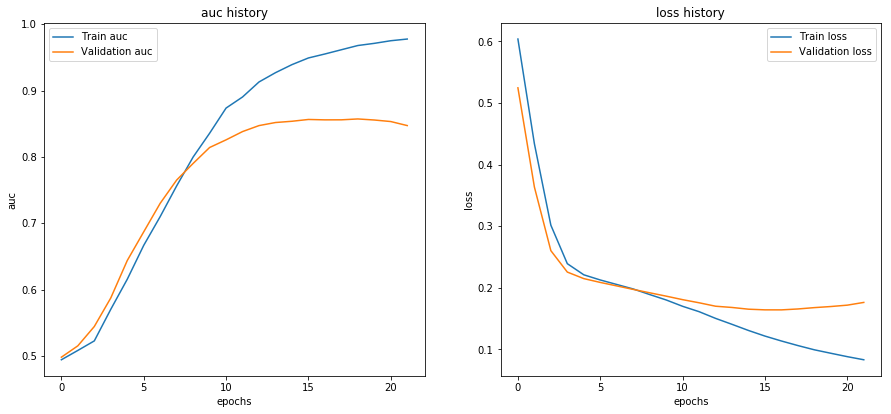

6555/6555 [==============================] - 0s 57us/sample
Input array sizes: [9, 6696, 4043, 127, 175, 442, 335, 2217, 69, 335]
Categorical levels: {'RESOURCE': 6696, 'MGR_ID': 4043, 'ROLE_ROLLUP_1': 127, 'ROLE_ROLLUP_2': 175, 'ROLE_DEPTNAME': 442, 'ROLE_TITLE': 335, 'ROLE_FAMILY_DESC': 2217, 'ROLE_FAMILY': 69, 'ROLE_CODE': 335}

Epoch 1/30
52/52 [==============================] - 7s 136ms/step - loss: 0.5888 - auc: 0.5132 - mAP: 0.9401 - val_loss: 0.5068 - val_auc: 0.5047 - val_mAP: 0.9423
Epoch 2/30
52/52 [==============================] - 3s 64ms/step - loss: 0.4181 - auc: 0.5067 - mAP: 0.9438 - val_loss: 0.3489 - val_auc: 0.5186 - val_mAP: 0.9447
Epoch 3/30
52/52 [==============================] - 4s 68ms/step - loss: 0.2913 - auc: 0.5302 - mAP: 0.9480 - val_loss: 0.2570 - val_auc: 0.5427 - val_mAP: 0.9485
Epoch 4/30
52/52 [==============================] - 3s 66ms/step - loss: 0.2395 - auc: 0.5626 - mAP: 0.9520 - val_loss: 0.2282 - val_auc: 0.5809 - val_mAP: 0.9538
Epoch 5/30
52

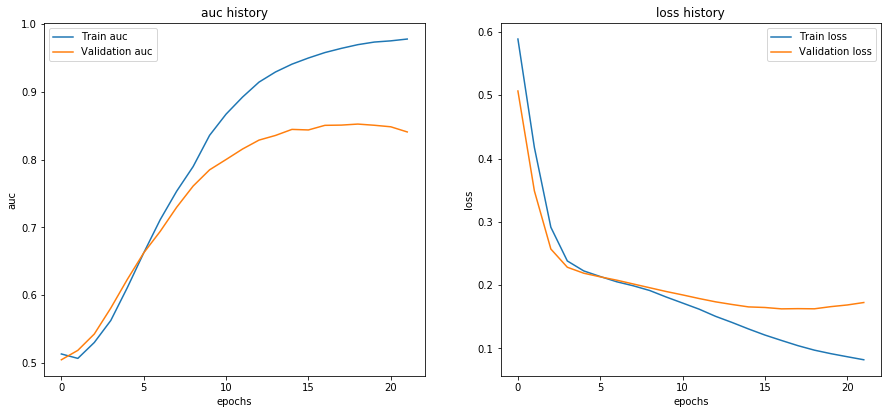

6555/6555 [==============================] - 0s 63us/sample
Input array sizes: [9, 6740, 4061, 129, 176, 448, 340, 2226, 69, 340]
Categorical levels: {'RESOURCE': 6740, 'MGR_ID': 4061, 'ROLE_ROLLUP_1': 129, 'ROLE_ROLLUP_2': 176, 'ROLE_DEPTNAME': 448, 'ROLE_TITLE': 340, 'ROLE_FAMILY_DESC': 2226, 'ROLE_FAMILY': 69, 'ROLE_CODE': 340}

Epoch 1/30
52/52 [==============================] - 7s 143ms/step - loss: 0.6083 - auc: 0.4974 - mAP: 0.9395 - val_loss: 0.5243 - val_auc: 0.5020 - val_mAP: 0.9443
Epoch 2/30
52/52 [==============================] - 4s 68ms/step - loss: 0.4392 - auc: 0.5035 - mAP: 0.9426 - val_loss: 0.3664 - val_auc: 0.5120 - val_mAP: 0.9476
Epoch 3/30
52/52 [==============================] - 4s 68ms/step - loss: 0.3073 - auc: 0.5156 - mAP: 0.9454 - val_loss: 0.2629 - val_auc: 0.5373 - val_mAP: 0.9518
Epoch 4/30
52/52 [==============================] - 4s 69ms/step - loss: 0.2445 - auc: 0.5508 - mAP: 0.9506 - val_loss: 0.2267 - val_auc: 0.5878 - val_mAP: 0.9580
Epoch 5/30
52

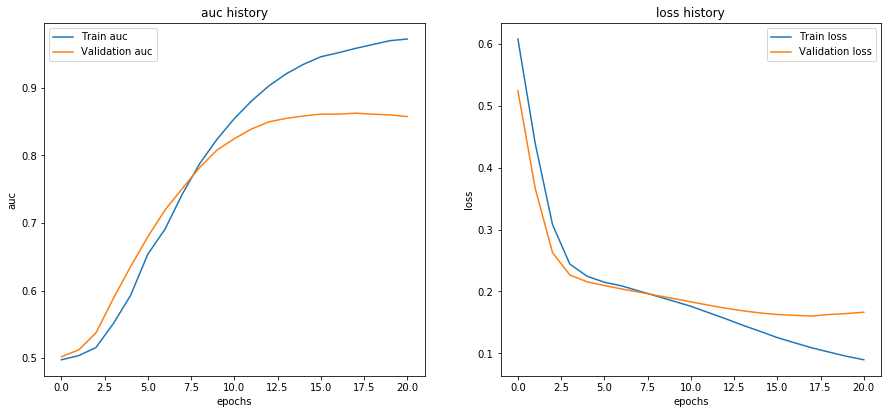

6553/6553 [==============================] - 0s 70us/sample
Input array sizes: [9, 6698, 4011, 128, 175, 442, 339, 2201, 69, 339]
Categorical levels: {'RESOURCE': 6698, 'MGR_ID': 4011, 'ROLE_ROLLUP_1': 128, 'ROLE_ROLLUP_2': 175, 'ROLE_DEPTNAME': 442, 'ROLE_TITLE': 339, 'ROLE_FAMILY_DESC': 2201, 'ROLE_FAMILY': 69, 'ROLE_CODE': 339}

Epoch 1/30
52/52 [==============================] - 8s 150ms/step - loss: 0.6022 - auc: 0.4817 - mAP: 0.9405 - val_loss: 0.5201 - val_auc: 0.5044 - val_mAP: 0.9446
Epoch 2/30
52/52 [==============================] - 3s 66ms/step - loss: 0.4364 - auc: 0.4888 - mAP: 0.9416 - val_loss: 0.3626 - val_auc: 0.5388 - val_mAP: 0.9494
Epoch 3/30
52/52 [==============================] - 3s 67ms/step - loss: 0.3064 - auc: 0.5031 - mAP: 0.9432 - val_loss: 0.2597 - val_auc: 0.5813 - val_mAP: 0.9556
Epoch 4/30
52/52 [==============================] - 3s 67ms/step - loss: 0.2425 - auc: 0.5493 - mAP: 0.9520 - val_loss: 0.2239 - val_auc: 0.6278 - val_mAP: 0.9612
Epoch 5/30
52

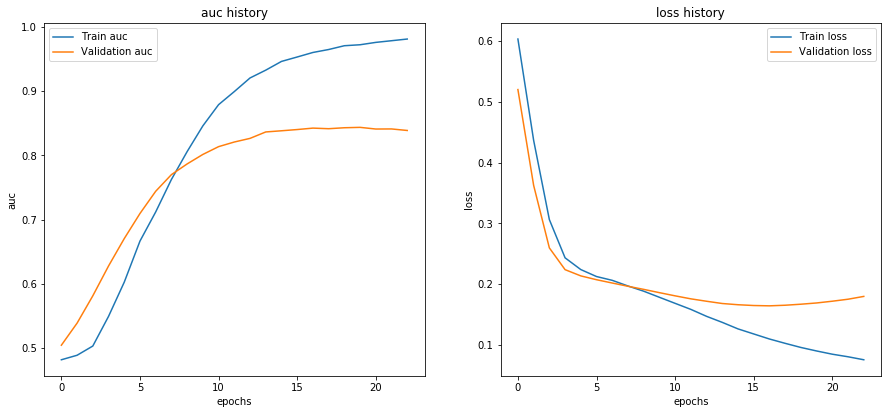

6553/6553 [==============================] - 0s 74us/sample
Input array sizes: [9, 6696, 4036, 126, 174, 445, 335, 2213, 68, 335]
Categorical levels: {'RESOURCE': 6696, 'MGR_ID': 4036, 'ROLE_ROLLUP_1': 126, 'ROLE_ROLLUP_2': 174, 'ROLE_DEPTNAME': 445, 'ROLE_TITLE': 335, 'ROLE_FAMILY_DESC': 2213, 'ROLE_FAMILY': 68, 'ROLE_CODE': 335}

Epoch 1/30
52/52 [==============================] - 9s 177ms/step - loss: 0.6123 - auc: 0.4852 - mAP: 0.9399 - val_loss: 0.5336 - val_auc: 0.4494 - val_mAP: 0.9368
Epoch 2/30
52/52 [==============================] - 3s 67ms/step - loss: 0.4438 - auc: 0.4996 - mAP: 0.9431 - val_loss: 0.3725 - val_auc: 0.4802 - val_mAP: 0.9413
Epoch 3/30
52/52 [==============================] - 4s 72ms/step - loss: 0.3051 - auc: 0.5215 - mAP: 0.9480 - val_loss: 0.2634 - val_auc: 0.5256 - val_mAP: 0.9469
Epoch 4/30
52/52 [==============================] - 4s 70ms/step - loss: 0.2397 - auc: 0.5698 - mAP: 0.9538 - val_loss: 0.2286 - val_auc: 0.5850 - val_mAP: 0.9535
Epoch 5/30
52

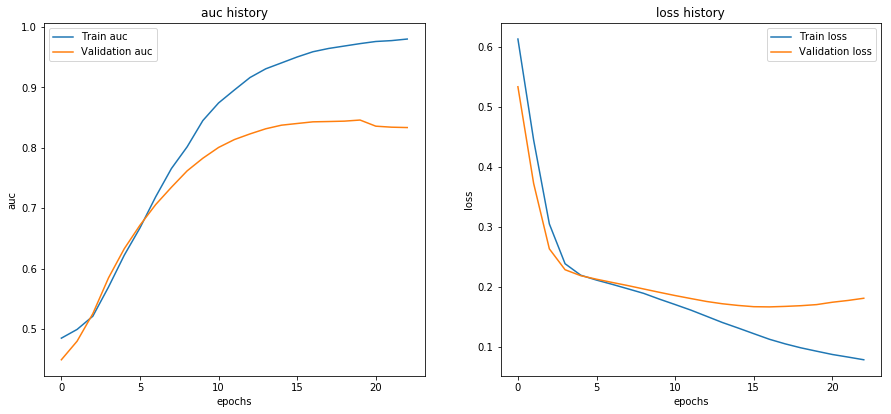

6553/6553 [==============================] - 1s 83us/sample


In [23]:
from deep_learning_for_tabular_data.tabular import TabularTransformer, DataGenerator

# Setting the CV strategy
skf = StratifiedKFold(n_splits=FOLDS, 
                      shuffle=True, 
                      random_state=SEED)

# CV Iteration
roc_auc = list()
average_precision = list()
oof = np.zeros(len(X))
best_iteration = list()

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    
    tb = TabularTransformer(numeric = numeric_variables,
                        ordinal = [],
                        lowcat  = [],
                        highcat = categorical_variables)

    tb.fit(X.iloc[train_idx])
    sizes = tb.shape(X.iloc[train_idx])
    categorical_levels = dict(zip(categorical_variables, sizes[1:]))
    print(f"Input array sizes: {sizes}")
    print(f"Categorical levels: {categorical_levels}\n")
    
    model = tabular_dnn(numeric_variables, categorical_variables,
                        categorical_levels, 
                        feature_selection_dropout=0.1,
                        categorical_dropout=0.1,
                        first_dense = 256,
                        second_dense = 256,
                        dense_dropout = 0.1,
                        activation_type=gelu)
    
    model = compile_model(model, binary_crossentropy, [AUC(name='auc'), mAP], Adam(learning_rate=0.0001))
    
    train_batch = DataGenerator(X.iloc[train_idx], 
                                y[train_idx],
                                tabular_transformer=tb,
                                batch_size=BATCH_SIZE,
                                shuffle=True)
    
    history = model.fit(train_batch,
                        validation_data=(tb.transform(X.iloc[test_idx]), y[test_idx]),
                        epochs=30,
                        callbacks=[model_checkpoint, early_stopping],
                        class_weight={0:1.0, 1:(np.sum(y==0) / np.sum(y==1))},
                        verbose=1)
    
    print("\nFOLD %i" % fold)
    plot_keras_history(history, measures=['auc', 'loss'])
    
    best_iteration.append(np.argmax(history.history['val_auc']) + 1)
    preds = model.predict(tb.transform(X.iloc[test_idx]),
                          verbose=1,
                          batch_size=1024).flatten()

    oof[test_idx] = preds

    roc_auc.append(roc_auc_score(y_true=y[test_idx], y_score=preds))
    average_precision.append(average_precision_score(y_true=y[test_idx], y_score=preds))

In [24]:
print("Average cv roc auc score %0.3f ± %0.3f" % (np.mean(roc_auc), np.std(roc_auc)))
print("Average cv roc average precision %0.3f ± %0.3f" % (np.mean(average_precision), np.std(average_precision)))

print("Roc auc score OOF %0.3f" % roc_auc_score(y_true=y, y_score=oof))
print("Average precision OOF %0.3f" % average_precision_score(y_true=y, y_score=oof))

Average cv roc auc score 0.854 ± 0.005
Average cv roc average precision 0.986 ± 0.001
Roc auc score OOF 0.853
Average precision OOF 0.986


In [25]:
# We train on all the examples, using a rule of thumb for the number of iterations

tb = TabularTransformer(numeric = numeric_variables,
                        ordinal = [],
                        lowcat  = [],
                        highcat = categorical_variables)

tb.fit(X)
sizes = tb.shape(X)
categorical_levels = dict(zip(categorical_variables, sizes[1:]))
print(f"Input array sizes: {sizes}")
print(f"Categorical levels: {categorical_levels}\n")

model = tabular_dnn(numeric_variables, categorical_variables,
                        categorical_levels, 
                        feature_selection_dropout=0.1,
                        categorical_dropout=0.1,
                        first_dense = 256,
                        second_dense = 256,
                        dense_dropout = 0.1,
                        activation_type=gelu)
    
model = compile_model(model, binary_crossentropy, [AUC(name='auc'), mAP], Adam(learning_rate=0.0001))    

train_batch = DataGenerator(X, y,
                            tabular_transformer=tb,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

history = model.fit(train_batch,
                    epochs=int(np.median(best_iteration)),
                    class_weight={0:1.0, 1:(np.sum(y==0) / np.sum(y==1))},
                    verbose=1)

Input array sizes: [9, 7520, 4245, 130, 179, 451, 345, 2360, 69, 345]
Categorical levels: {'RESOURCE': 7520, 'MGR_ID': 4245, 'ROLE_ROLLUP_1': 130, 'ROLE_ROLLUP_2': 179, 'ROLE_DEPTNAME': 451, 'ROLE_TITLE': 345, 'ROLE_FAMILY_DESC': 2360, 'ROLE_FAMILY': 69, 'ROLE_CODE': 345}

Epoch 1/19
65/65 [==============================] - 9s 135ms/step - loss: 0.6031 - auc: 0.4688 - mAP: 0.9402
Epoch 2/19
65/65 [==============================] - 4s 62ms/step - loss: 0.4030 - auc: 0.4797 - mAP: 0.9422
Epoch 3/19
65/65 [==============================] - 4s 61ms/step - loss: 0.2686 - auc: 0.5203 - mAP: 0.9483
Epoch 4/19
65/65 [==============================] - 4s 62ms/step - loss: 0.2466 - auc: 0.5732 - mAP: nan
Epoch 5/19
65/65 [==============================] - 4s 62ms/step - loss: 0.2195 - auc: 0.6186 - mAP: 0.9606
Epoch 6/19
65/65 [==============================] - 4s 62ms/step - loss: 0.2299 - auc: 0.6628 - mAP: nan
Epoch 7/19
65/65 [==============================] - 4s 61ms/step - loss: 0.2051 - a

In [26]:
# Predicting and submission
preds = model.predict(tb.transform(Xt[X.columns]),
                      verbose=1,
                      batch_size=1024).flatten()

submission = pd.DataFrame(Xt.id)
submission['Action'] = preds
submission.to_csv("tabular_dnn_submission.csv", index=False)

tabular_dnn_submission = submission.copy()

58921/58921 [==============================] - 2s 35us/sample


## Blending together the GBM and DNN solutions

In [27]:
from scipy.stats import rankdata

# We use normalized ranks because probabilities emissions from the two models may differ
dnn_rank = rankdata(tabular_dnn_submission.Action, method='dense') / len(Xt)
cat_rank = rankdata(cat_boost_submission.Action, method='dense') / len(Xt)

submission = pd.DataFrame(Xt.id)
submission['Action'] = 0.5 * dnn_rank + 0.5 * cat_rank 
submission.to_csv("blended_submission.csv", index=False)